***Kernel Density Estimator***

In [1]:
import numpy as np

In [2]:
bq_data = np.loadtxt('./data/BQmat_orig.txt', delimiter=',')

#### I. 3D surface plot ####

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [6]:
X = np.linspace(18, 95, num = 78)
Y = np.linspace(1, 7, num = 7)

X_i, Y_i = np.mgrid[18:95:78j, 1:7:7j]

In [7]:
def plot_3D_surface(dist):

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X_i, Y_i, dist, rstride=5)
    ax.set_xlabel("ages")
    ax.set_ylabel("income groups")
    ax.set_zlabel("Percent of income")
    
    return

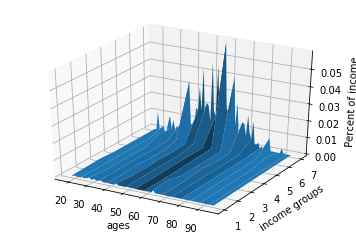

In [8]:
plot_3D_surface(bq_data)

#### II. bivariate kernel density estimator ####

In [69]:
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

In [70]:
def get_frequency(times):
    
    data_list = []
    bq_data_new = bq_data * times
    for i in range(len(X)):
        x = X[i]
        for j in range(len(Y)):
            y = Y[j]
            num = bq_data_new[i,j]
            data = (x, y)
            for time in range(int(round(num))):
                data_list.append(data)
                data_df = pd.DataFrame(data_list)
    
    return data_df

In [75]:
def get_estimate(times):
    
    data_df = get_frequency(times)
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=LeaveOneOut(data_df.shape[0]))
    grid.fit(data_df)
    bandwidth = grid.best_params_['bandwidth']
    kernel = gaussian_kde(data_df.T, bw_method=bandwidth)
    coords = np.vstack([item.ravel() for item in [X_i, Y_i]])

    Z = np.reshape(kernel(coords), X_i.shape)
    Z_scaled = Z / float(np.sum(Z))
    
    return Z_scaled, bandwidth

In [76]:
Z_scaled, bandwidth = get_estimate(1000)

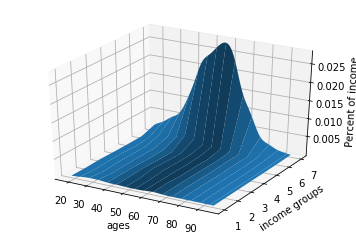

In [77]:
plot_3D_surface(Z_scaled)

In [79]:
print('The λ we choose is', bandwidth, 'which is got from leave-one-out cross-validation based on the sample size')

The λ we choose is 0.2535364493970112 which is got from leave-one-out cross-validation based on the sample size


In [83]:
print('The estimate of bequest recipients who are age 61 in the 6th lifetime income category is', Z_scaled[43, 5])

The estimate of bequest recipients who are age 61 in the 6th lifetime income category is 0.0009233266576317442


***Interaction Term***

In [87]:
BIDEN = pd.read_csv('./data/biden.csv')
BIDEN.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [102]:
BIDEN['constant'] = 1
Y = BIDEN['biden']
X1 = BIDEN['age']
X2 = BIDEN['educ']
CONSTANT = BIDEN['constant']
X = pd.concat([CONSTANT, X1, X2, X1 * X2], axis = 1)

In [103]:
import statsmodels.api as sm
reg1 = sm.OLS(endog=Y, exog=X, missing='drop')

In [104]:
results = reg1.fit()

In [107]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        01:59:42   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      37.5491      9.491      3.956      0.0

#### I. Marginal effect of age ####

#### II. Marginal effect of education ####